<a href="https://colab.research.google.com/github/zosiawidawska/Pliki/blob/main/NLP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prawo Heapsa i Prawo Herdana w polskim korpusie

Wzrost słownictwa w korpusach języka naturalnego opisują dwa klasyczne prawa empiryczne:

**Prawo Heapsa (wzrost słownictwa)**

$$|V| = K \cdot N^\beta$$

gdzie: $|V|$ = rozmiar słownika (liczba unikalnych typów słów) po napotkaniu $N$ tokenów, $K$ oraz $\beta$ to stałe dodatnie zależne od korpusu ($0 < \beta < 1$, zazwyczaj w granicach 0,4–0,6)


Porównajmy na przykładzie danych empirycznych i naszych teoretycznych.

In [6]:
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
import requests
url = "https://wolnelektury.pl/media/book/txt/pan-tadeusz.txt"
response = requests.get(url)

if response.status_code == 200:
    text = response.text
    print(f"Pobrano {len(text)} znaków.")
else:
    print("Błąd pobierania.")

Pobrano 458185 znaków.


Implementacja prawa Heapsa

In [7]:
def heaps_law(k, N, beta):
  return k * (N**beta)

Tworzymy słownik i przekształcamy tekst na tokeny.

In [9]:
tokens = text.lower().split()
vocab = set()
step = 100

x_tokens = []
y_vocab = []
for i in range(0, len(tokens), step):
  vocab.update(tokens[i:i+step])
  x_tokens.append(i+step)
  y_vocab.append(len(vocab))

Liczymy liczbę instancji ze wzoru (dane teoretyczne).

In [13]:
k = 3
beta = 0.8

y_theory = heaps_law(k, np.array(x_tokens), beta)

Rysujemy wykres

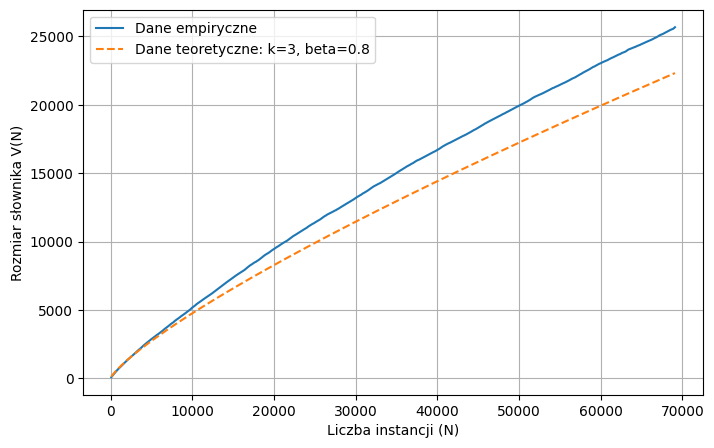

In [14]:
plt.figure(figsize = (8,5))
plt.plot(x_tokens, y_vocab, label = "Dane empiryczne")
plt.plot(x_tokens, y_theory, '--', label = f"Dane teoretyczne: k={k}, beta={beta}")
plt.xlabel("Liczba instancji (N)")
plt.ylabel("Rozmiar słownika V(N)")
plt.legend()
plt.grid(True)
plt.show()

Jak wyestymować stałe k oraz beta?
- przyjżyjmy się równaniu

In [15]:
!pip install scipy

In [17]:
from scipy import stats

In [20]:
log_x = np.log(x_tokens)
log_y = np.log(y_vocab)

slope, intercept, r, p, se =  stats.linregress(log_x, log_y)
print(slope, intercept, r, p, se)

beta = slope
k = np.exp(intercept)
print(beta, k)

0.8470422940417611 0.7423812693306804 0.9997603230566801 0.0 0.0007066456503566285
0.8470422940417611 2.1009324486158634


In [ ]:
# plt.figure(figsize=(8,5))
# plt.plot(x_tokens, y_vocab, label="Empiryczne")
# plt.plot(x_tokens, y_fit, '--', label="Dopasowanie Heapsa")
# plt.xlabel("Liczba instancji (N)")
# plt.ylabel("Rozmiar słownika V(N)")
# plt.grid(True)
# plt.legend()
# plt.show()

In [24]:
k = 2.1009324486158634
beta = 0.8470422940417611

y_fit = heaps_law(k, np.array(x_tokens), beta)

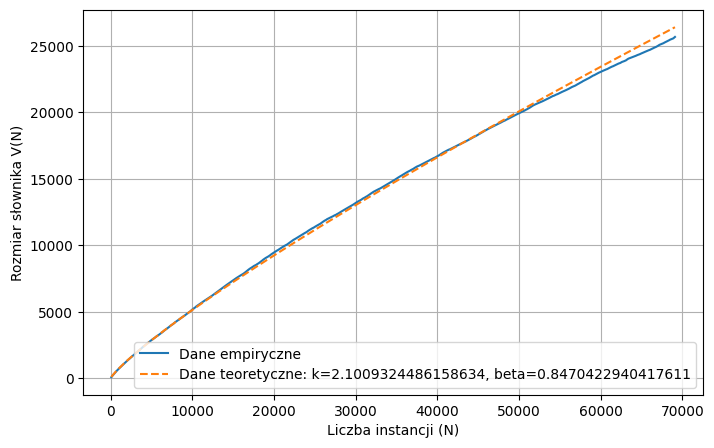

In [25]:
plt.figure(figsize = (8,5))
plt.plot(x_tokens, y_vocab, label = "Dane empiryczne")
plt.plot(x_tokens, y_fit, '--', label = f"Dane teoretyczne: k={k}, beta={beta}")
plt.xlabel("Liczba instancji (N)")
plt.ylabel("Rozmiar słownika V(N)")
plt.legend()
plt.grid(True)
plt.show()

## Algorytm BPE

In [63]:
# !pip install collections
from collections import Counter
text = "low lower the lowest low"

In [69]:
from typing import Counter
#praca własna
def split_to_chars(C):
  return list(C)

def find_most_frequent_pair(token_list):
    pairs = []

    for i in range(len(token_list) - 1):
      pairs.append((token_list[i], token_list[i+1]))
    if not pairs:
        return None, None, 0

    counter = Counter(pairs)
    (pairs, count) = counter.most_common(1)[0]
    return pairs[0], pairs[1], count

def replace_occurrences(token_list, pair, tNEW):
  tL, tR = pair
  new_token_list = []
  i = 0

  while i < len(token_list):
    if i < len(token_list)-1 and token_list[i]==tL and token_list[i+1]==tR:
      new_token_list.append(tNEW)
      i+=2
    else:
      new_token_list.append(token_list[i])
      i+=1

  return new_token_list


In [70]:
def byte_pair_encoding(C, k):
    # initial set of tokens is characters
    chars = split_to_chars(C)
    V = set(chars)
    print(V)

    for i in range(1, k + 1): # merge tokens k times
        tL, tR, _ = find_most_frequent_pair(chars)
        tNEW = tL + tR        # make new token by concatenating
        V.add(tNEW)
        print(V)           # update the vocabulary

        # replace each occurrence of tL, tR in C with tNEW
        chars = replace_occurrences(chars, (tL, tR), tNEW)

    return V


In [71]:
#testowanie
vocab = byte_pair_encoding(C=text, k=4)


{'w', 'h', 'o', ' ', 'l', 't', 's', 'e', 'r'}
{'w', 'h', 'o', ' ', 'l', 't', 's', 'e', 'lo', 'r'}
{'w', 'h', 'o', ' ', 'l', 't', 's', 'e', 'lo', 'r', 'low'}
{'w', 'h', 'o', ' low', ' ', 'l', 't', 's', 'e', 'lo', 'r', 'low'}
{'w', 'h', 'o', ' lowe', ' low', ' ', 'l', 't', 's', 'e', 'lo', 'r', 'low'}


Jak znaleźć optymalne k?

In [76]:
def find_optimal_k(C):
  tokens = split_to_chars(C)
  k = 0

  while True:
    tL, tR, count = find_most_frequent_pair(tokens)

    if count < 2:
      break
    tokens = replace_occurrences(tokens, (tL, tR), tL+tR)
    k+=1
  return k

In [77]:
print(find_optimal_k(C=text))

4


## Unicode, UTF-32, UTF-16, UTF-8

Text to ciąg znaków unicode.

In [84]:
text_pl = "Nieprzewidywalność pogody 🌧 sprawia, że zawsze noszę okulary 😎 i mam nadzieję na słońce 🌞!"

In [86]:
#ord zwraca kod Unicode dla pojedynczego znaku

print(ord('😎'))
print([ord(x) for x in text_pl])

128526
[78, 105, 101, 112, 114, 122, 101, 119, 105, 100, 121, 119, 97, 108, 110, 111, 347, 263, 32, 112, 111, 103, 111, 100, 121, 32, 127783, 32, 115, 112, 114, 97, 119, 105, 97, 44, 32, 380, 101, 32, 122, 97, 119, 115, 122, 101, 32, 110, 111, 115, 122, 281, 32, 111, 107, 117, 108, 97, 114, 121, 32, 128526, 32, 105, 32, 109, 97, 109, 32, 110, 97, 100, 122, 105, 101, 106, 281, 32, 110, 97, 32, 115, 322, 111, 324, 99, 101, 32, 127774, 33]


Ale nie możemy używać kodu Unicode bezpośrednio i potrzebujemy odpowiedniego kodowania

In [88]:
slowo = 'pogoda'

print([ord(x) for x in slowo])
print(f"Representacja utf-32: {list(slowo.encode('utf-32'))}")
print(f"Representacja utf-16: {list(slowo.encode('utf-16'))}")
print(f"Representacja utf-8: {list(slowo.encode('utf-8'))}")

[112, 111, 103, 111, 100, 97]
Representacja utf-32: [255, 254, 0, 0, 112, 0, 0, 0, 111, 0, 0, 0, 103, 0, 0, 0, 111, 0, 0, 0, 100, 0, 0, 0, 97, 0, 0, 0]
Representacja utf-16: [255, 254, 112, 0, 111, 0, 103, 0, 111, 0, 100, 0, 97, 0]
Representacja utf-8: [112, 111, 103, 111, 100, 97]


## Algorytm BPE na bajtach

In [113]:
def encode_to_bytes(text):
    return list(text.encode('utf-8'))

In [112]:
encode_to_bytes(slowo)

[112, 111, 103, 111, 100, 97]

In [110]:
def byte_pair_encoding_bytes(text, k, verbose=True):
  tokens = encode_to_bytes(text)

  merges = {}
  next_token_id = 257
  if verbose:
    print(f"Start: {tokens}")
    print(f"Liczba tokenów na starcie: {len(tokens)}")

  for i in range(1, k+1):
    tL, tR, count = find_most_frequent_pair(tokens)
    merges[(tL, tR)] = next_token_id

    if verbose:
      print(f"Krok {i}: Łączę ({tL}, {tR}) -> {next_token_id} (wystąpień: {count})")

    tokens = replace_occurrences(tokens, (tL, tR), next_token_id)
    next_token_id += 1

  return tokens, merges

In [111]:
#Testowanie
final_tokens, learned_merges = byte_pair_encoding_bytes(text_pl, k=5)

print("\nWynik końcowy (tokeny ID):")
print(final_tokens)

print("\nNauczone reguły (Słownik):")
for pair, new_id in learned_merges.items():
    print(f"Para {pair} -> Token {new_id}")

Start: [78, 105, 101, 112, 114, 122, 101, 119, 105, 100, 121, 119, 97, 108, 110, 111, 197, 155, 196, 135, 32, 112, 111, 103, 111, 100, 121, 32, 240, 159, 140, 167, 32, 115, 112, 114, 97, 119, 105, 97, 44, 32, 197, 188, 101, 32, 122, 97, 119, 115, 122, 101, 32, 110, 111, 115, 122, 196, 153, 32, 111, 107, 117, 108, 97, 114, 121, 32, 240, 159, 152, 142, 32, 105, 32, 109, 97, 109, 32, 110, 97, 100, 122, 105, 101, 106, 196, 153, 32, 110, 97, 32, 115, 197, 130, 111, 197, 132, 99, 101, 32, 240, 159, 140, 158, 33]
Liczba tokenów na starcie: 106
Krok 1: Łączę (32, 240) -> 257 (wystąpień: 3)
Krok 2: Łączę (257, 159) -> 258 (wystąpień: 3)
Krok 3: Łączę (32, 110) -> 259 (wystąpień: 3)
Krok 4: Łączę (105, 101) -> 260 (wystąpień: 2)
Krok 5: Łączę (112, 114) -> 261 (wystąpień: 2)

Wynik końcowy (tokeny ID):
[78, 260, 261, 122, 101, 119, 105, 100, 121, 119, 97, 108, 110, 111, 197, 155, 196, 135, 32, 112, 111, 103, 111, 100, 121, 258, 140, 167, 32, 115, 261, 97, 119, 105, 97, 44, 32, 197, 188, 101, 32,